 # Start

### Importing the Libraries

In [76]:
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd
import seaborn as sns

from ESN_Cell import *
from ddeint import ddeint

import os
os.getcwd()

'/home/tah/Documents/Computation_EOC/esn-neuroevolution'

### Resetting the Graph

In [77]:
tf.reset_default_graph()

## Simulating the Mackey-Glass Equation
#### for 6 different 'n' values

In [78]:
model = lambda X,t,beta,n,tau,gamma : beta*((X(t-tau))/(1 + X(t-tau)**n)) - gamma*X(t)

X_0 = lambda t:0.5 # history before t=0

X_ts = {}

bifurcation_para = [4.5, 6, 7.5, 8.5, 9.5, 9.6, 9.65, 9.7, 9.8, 9.9, 10, 11, 15, 20]

for i, n in enumerate(bifurcation_para):
    t = linspace(0,100,10000)
    X_t = ddeint(model, X_0, t, fargs=(2, n, 2, 1)) #beta=2, n=n, tau=2, gamma=1
    X_ts[n] = X_t    

#### Plotting the input

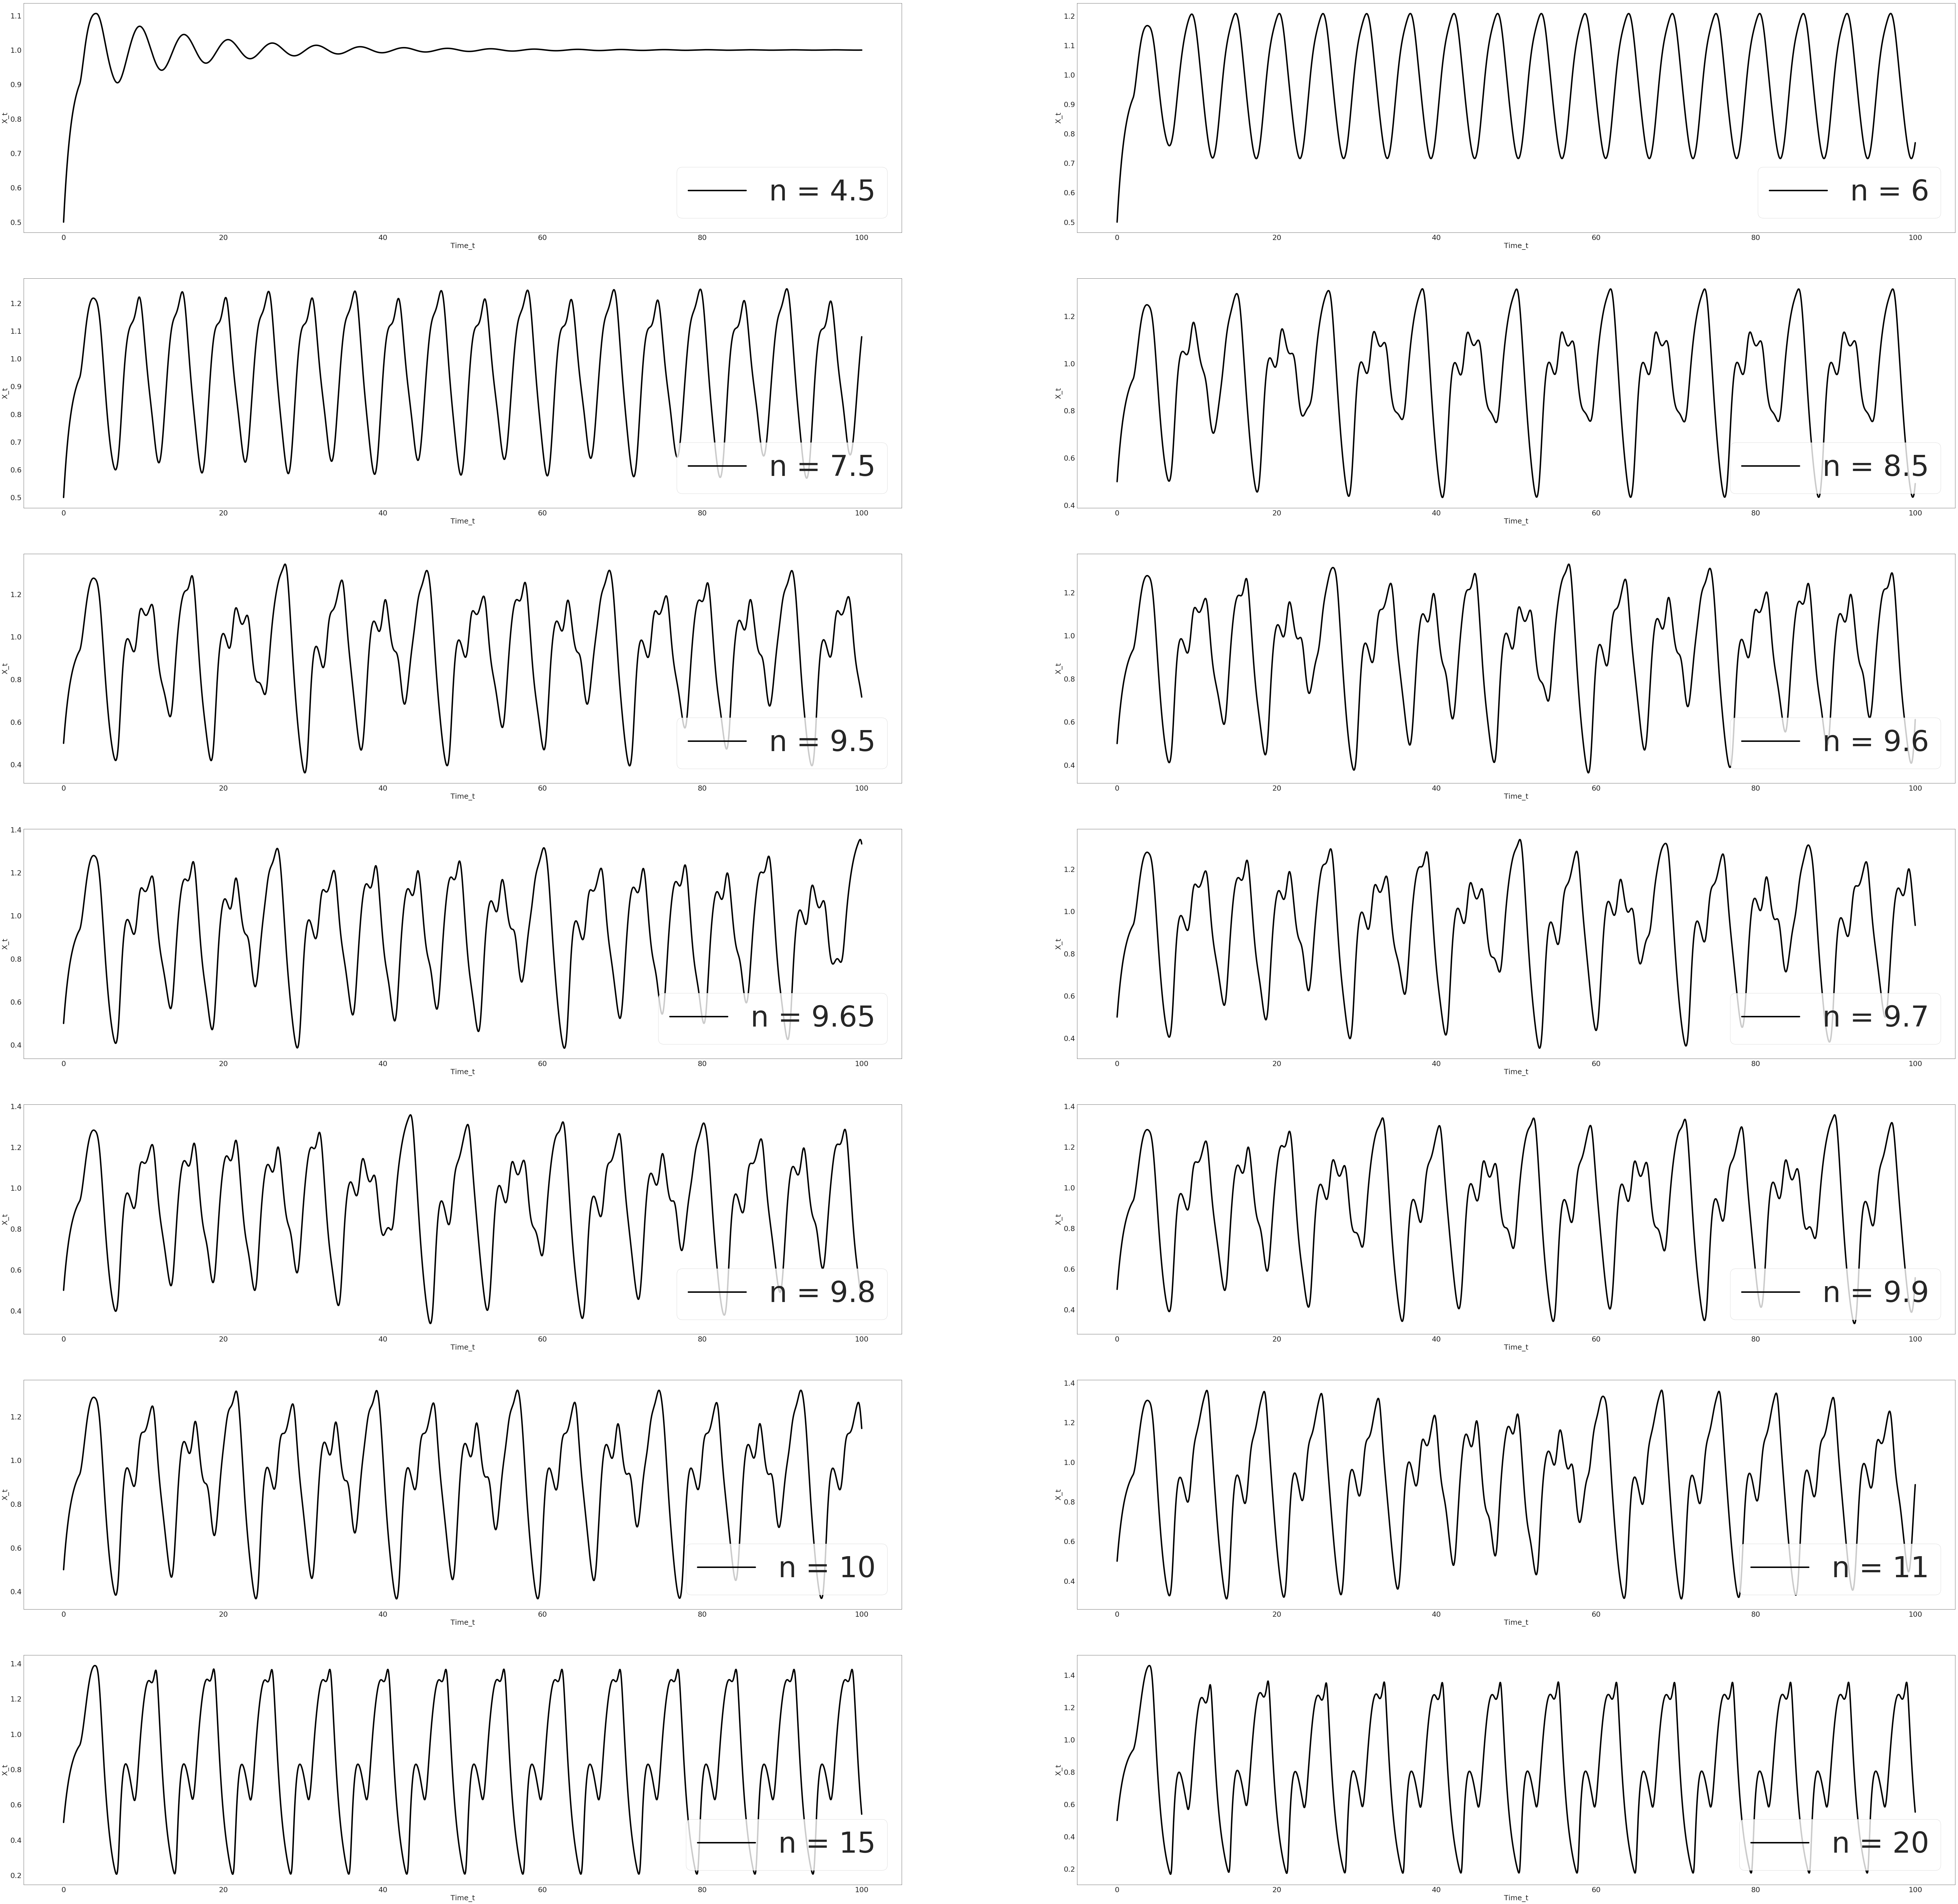

In [48]:
plt.figure(figsize=(120,120))
plt.rcParams.update({'font.size': 25})

for i, n in enumerate(bifurcation_para):
    plt.subplot(7,2,i+1)
    plt.plot(t, X_ts[n],label= "n = {}".format(n), color='black', lw=5.0)
    plt.xlabel("Time_t")
    plt.ylabel("X_t")
    plt.legend(loc="lower right", prop={'size': 100})

plt.show()


In [79]:
batch_size = 1
length_ts = len(X_ts[4.5])

X_ts_ = {}

for _,n in enumerate(X_ts):
    X_ts_[n] = np.reshape(X_ts[n], [batch_size, length_ts, 1]) #reshaped to: [batch_size, time, elements]


## Defining ESN Architecture Parameters

In [80]:
res_units = 100
in_units = 1

ESN_arch = [in_units, res_units]

## Defining ESN Variables/Parameters

In [81]:
leak_rate = tf.placeholder(tf.float32, shape=[None])
#Lower value of leak_rate (alpha) denotes lower influence of current state x(n) and higher influence of
#previous state x(n-1) in determination of the next state: X(n) = (1-alpha)*x(n-1) + alpha*x(n)

activation = tf.tanh
weights_variance = 0.1
sparseness = True
sparsity = 0.1 # 10% connectivity in the reservoir

## Instantiating the ESN Cell

In [82]:
esn = ESN(ESN_arch, activation, leak_rate, weights_variance, sparsity, sparseness)

## Computing ESN States

In [83]:
spectral_rad = esn.__dict__['spectral_radius'] #value of the spectral radius of the 'esn'
w_res = esn.__dict__['weights_res']
w_in = esn.__dict__['weights_in']

#Placeholders for feeding during session run
inputs = tf.placeholder(tf.float32, [batch_size, length_ts, in_units])
init_state = tf.placeholder(tf.float32, [None, res_units])


#Using the tensorflow API to compute the output of the ESN
output_state, last_state = tf.nn.dynamic_rnn(esn, inputs, initial_state=init_state)
print(output_state.shape, last_state.shape)

outputs = tf.reshape(output_state, [length_ts, res_units])

(1, 10000, 100) (?, 100)


## Defining Training Parameters

In [84]:
#Training on the first 5000 time steps for future prediction
#And, using the remaining 5000 time steps for testing on predictions
train_size = 5000

#length of initial transient
init_transient = 1000

# training data
train_states = tf.cast(outputs[init_transient:train_size+init_transient], dtype="float64")
train_target = tf.cast(tf.squeeze(inputs[:, init_transient+1:train_size+init_transient+1, :], axis=0), \
                       dtype="float64")
print(train_states.shape, train_target.shape)

#test data
test_states = tf.cast(outputs[train_size+init_transient:], dtype="float64")
test_target = tf.cast(tf.squeeze(inputs[:, train_size+init_transient+1:, :], axis=0), dtype="float64")
print(test_states.shape, test_target.shape)

(5000, 100) (5000, 1)
(4000, 100) (3999, 1)


## Ridge Regression to compute Output

In [85]:
beta = 0.1 #'Beta' value for regularization in ridge regression

X_XT = tf.matmul(tf.transpose(train_states),train_states) #X_XT is 100x100
B_I = tf.cast(tf.scalar_mul(beta, tf.eye(int(outputs.shape[1]))), dtype="float64") #B_I is 100x100

weights_out = tf.matmul(tf.matmul(tf.transpose(train_target), train_states), tf.linalg.inv(X_XT + B_I))

weights_out = tf.transpose(weights_out)
print(weights_out.shape)

#Computing Predictions
test_out = tf.matmul(test_states, weights_out)[:-1]
print(test_out.shape)

norm_test_target = tf.math.l2_normalize(test_target)
norm_test_out = tf.math.l2_normalize(test_out)

#Computing Mean Squared Loss
MSE = tf.losses.mean_squared_error(norm_test_target, norm_test_out)

(100, 1)
(3999, 1)


## Training the ESN for each MGE series

Mean Squared Error for n = 4.5 : 3.1584442092974507e-12


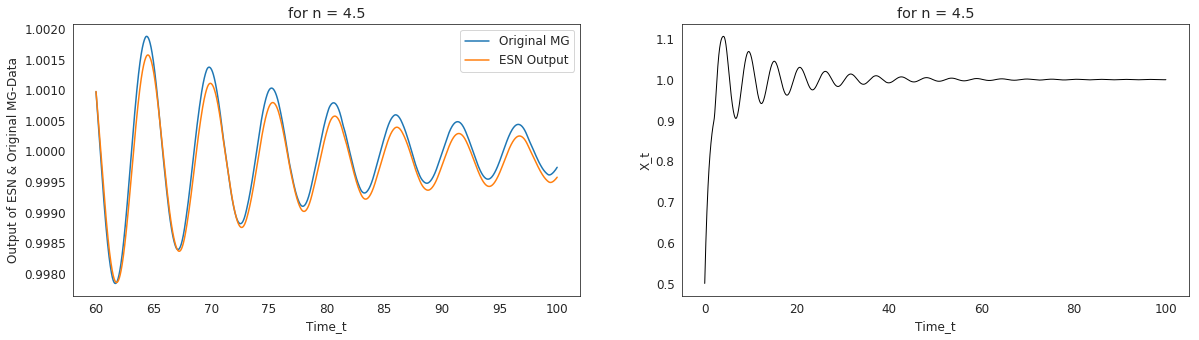

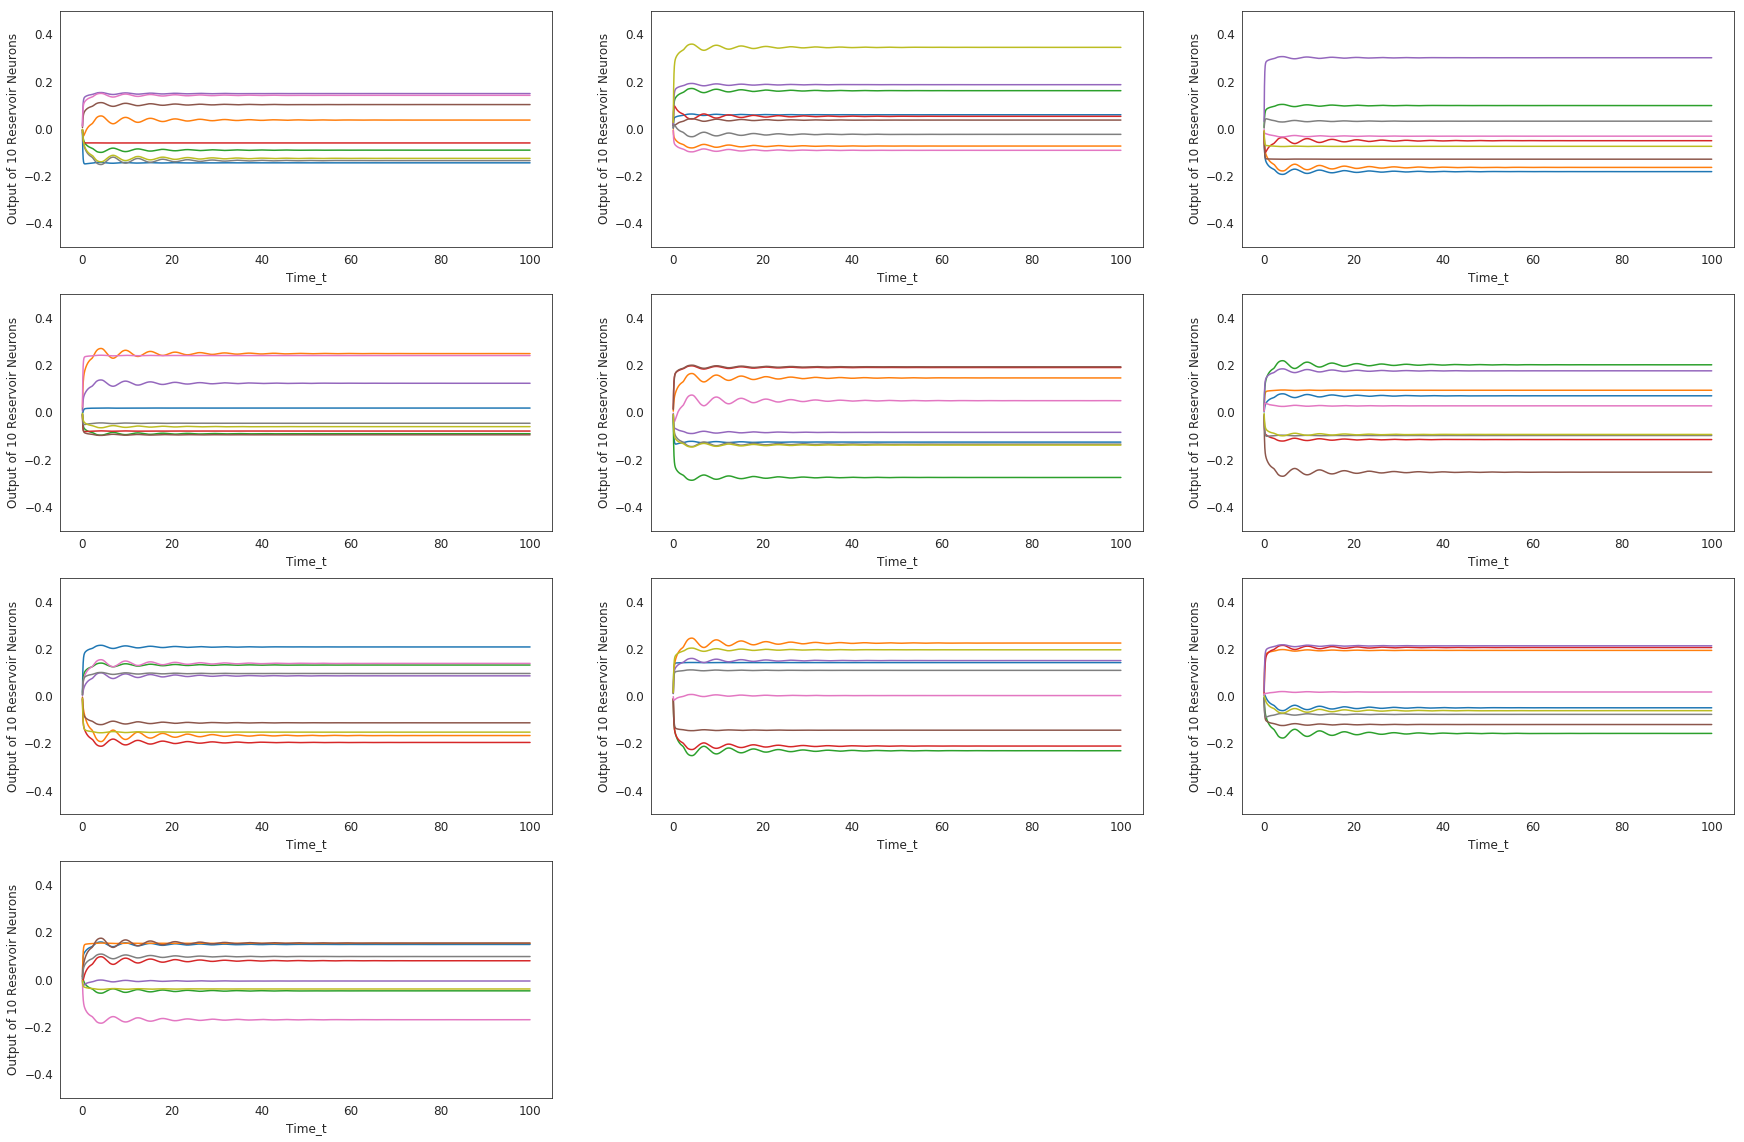

Mean Squared Error for n = 9.5 : 6.529202067895312e-08


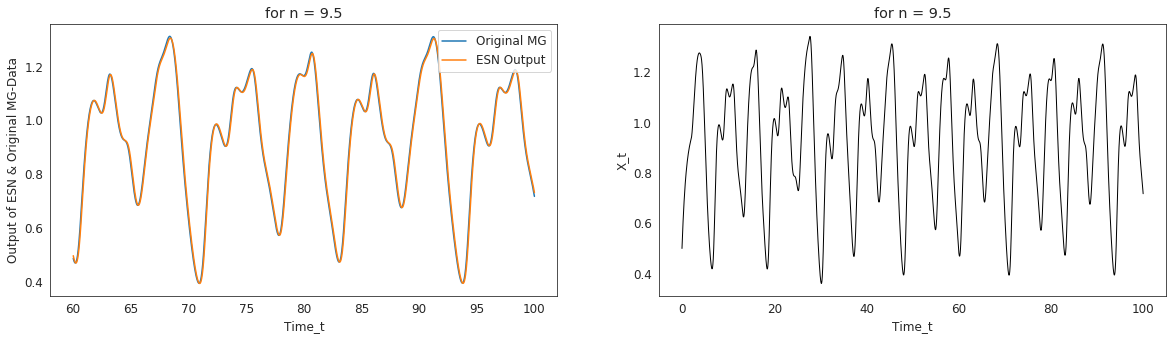

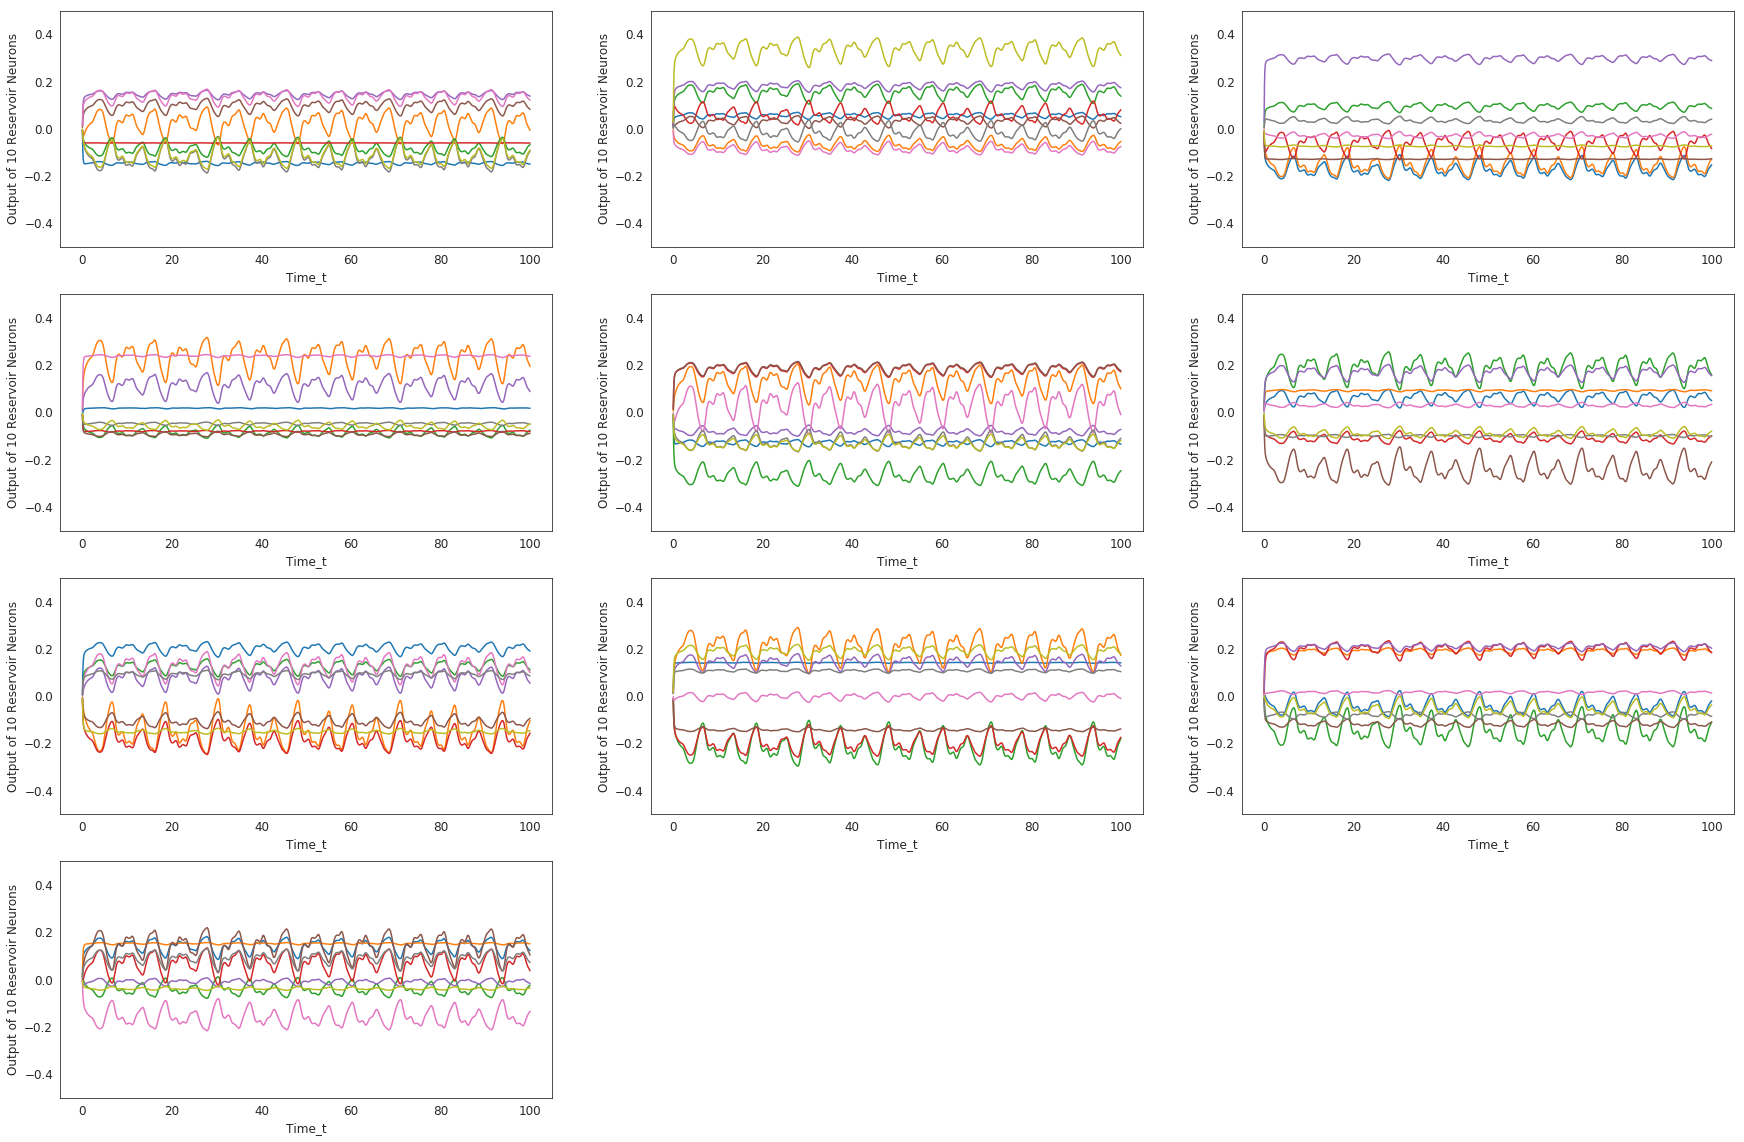

Mean Squared Error for n = 4.5 : 9.36848038382565e-13


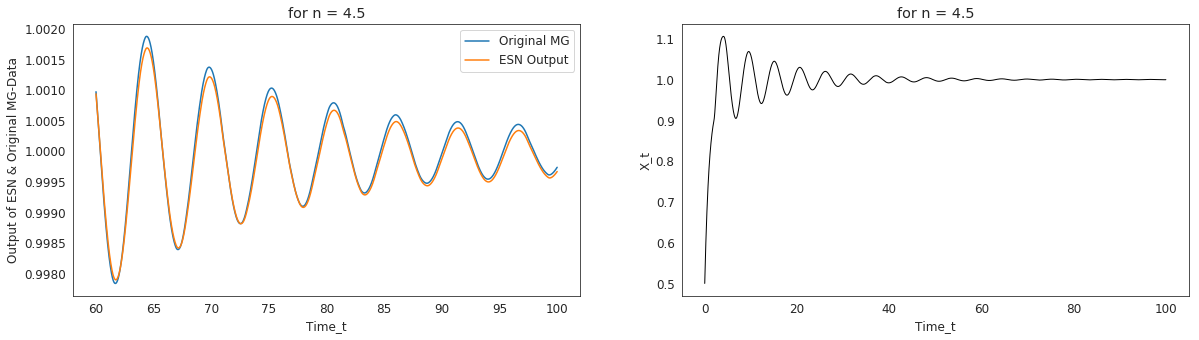

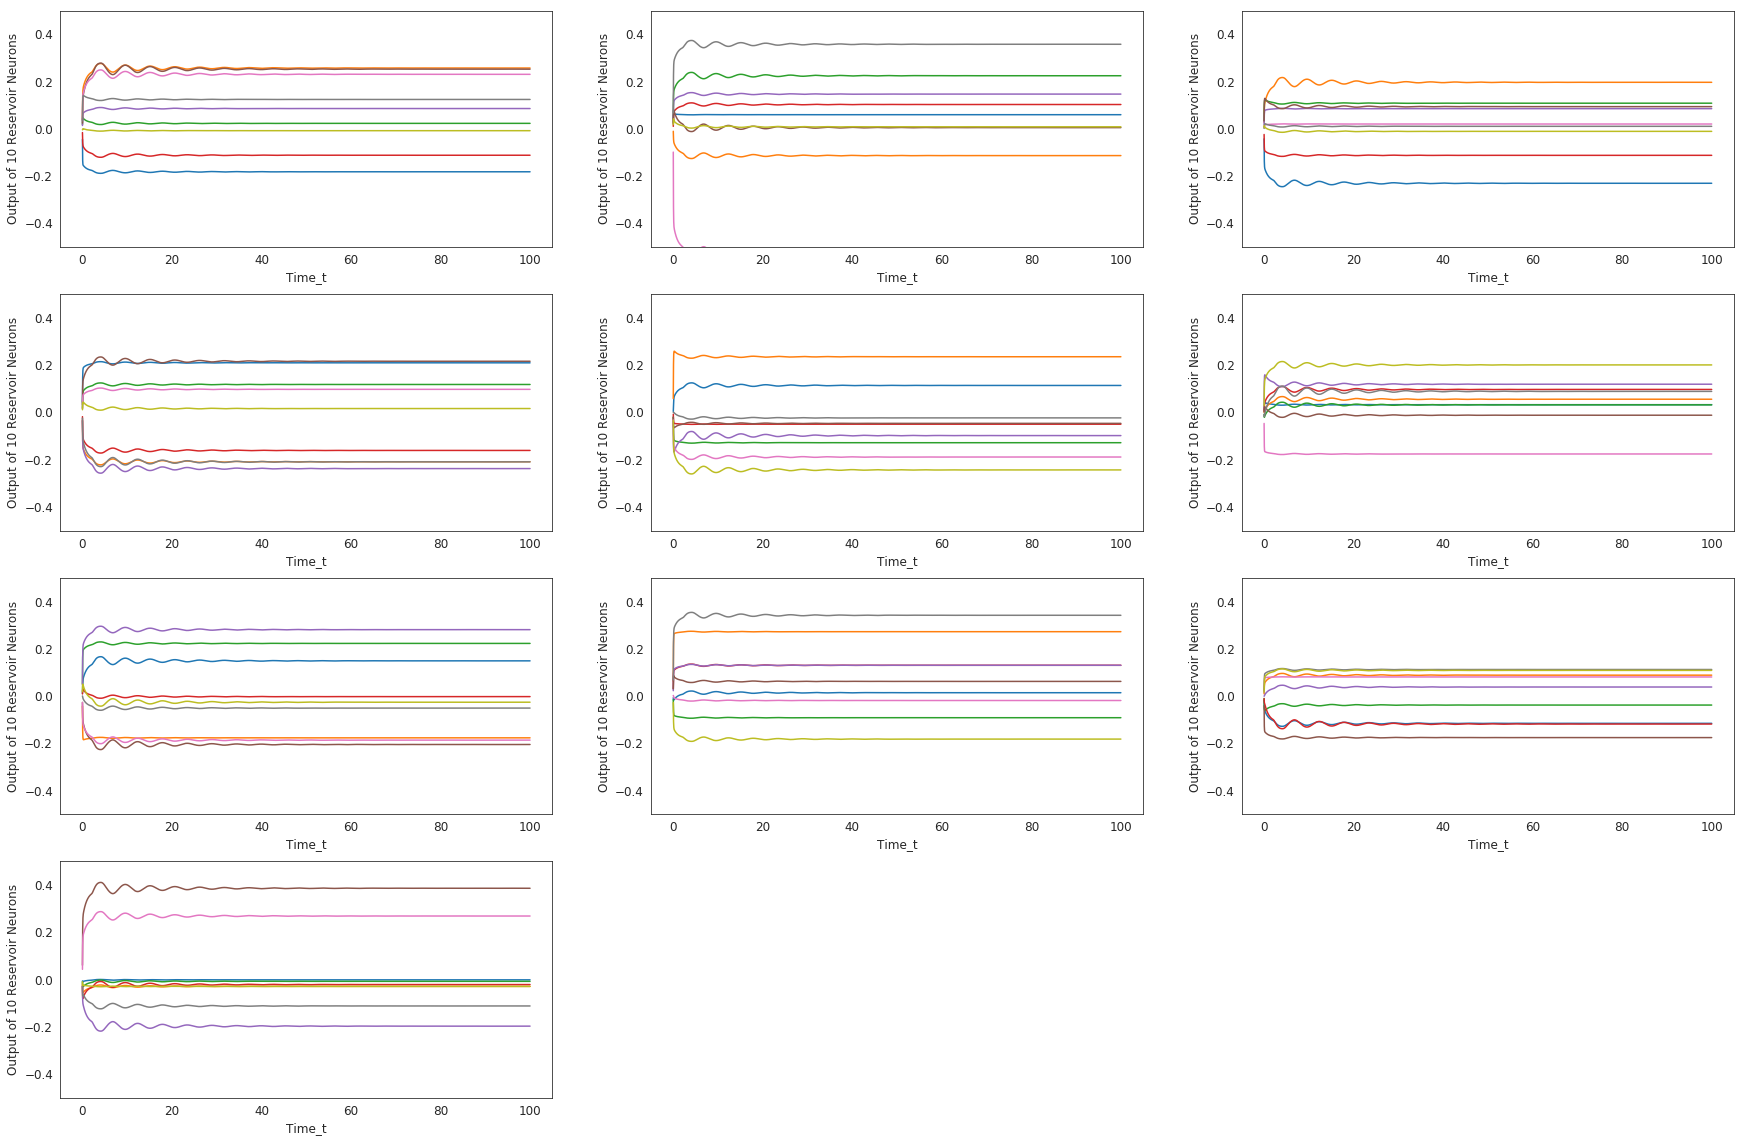

Mean Squared Error for n = 9.5 : 2.8623233561120287e-08


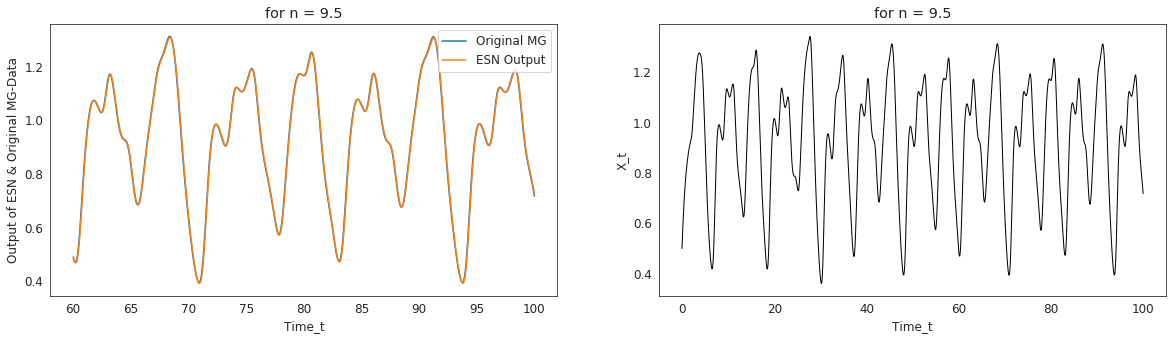

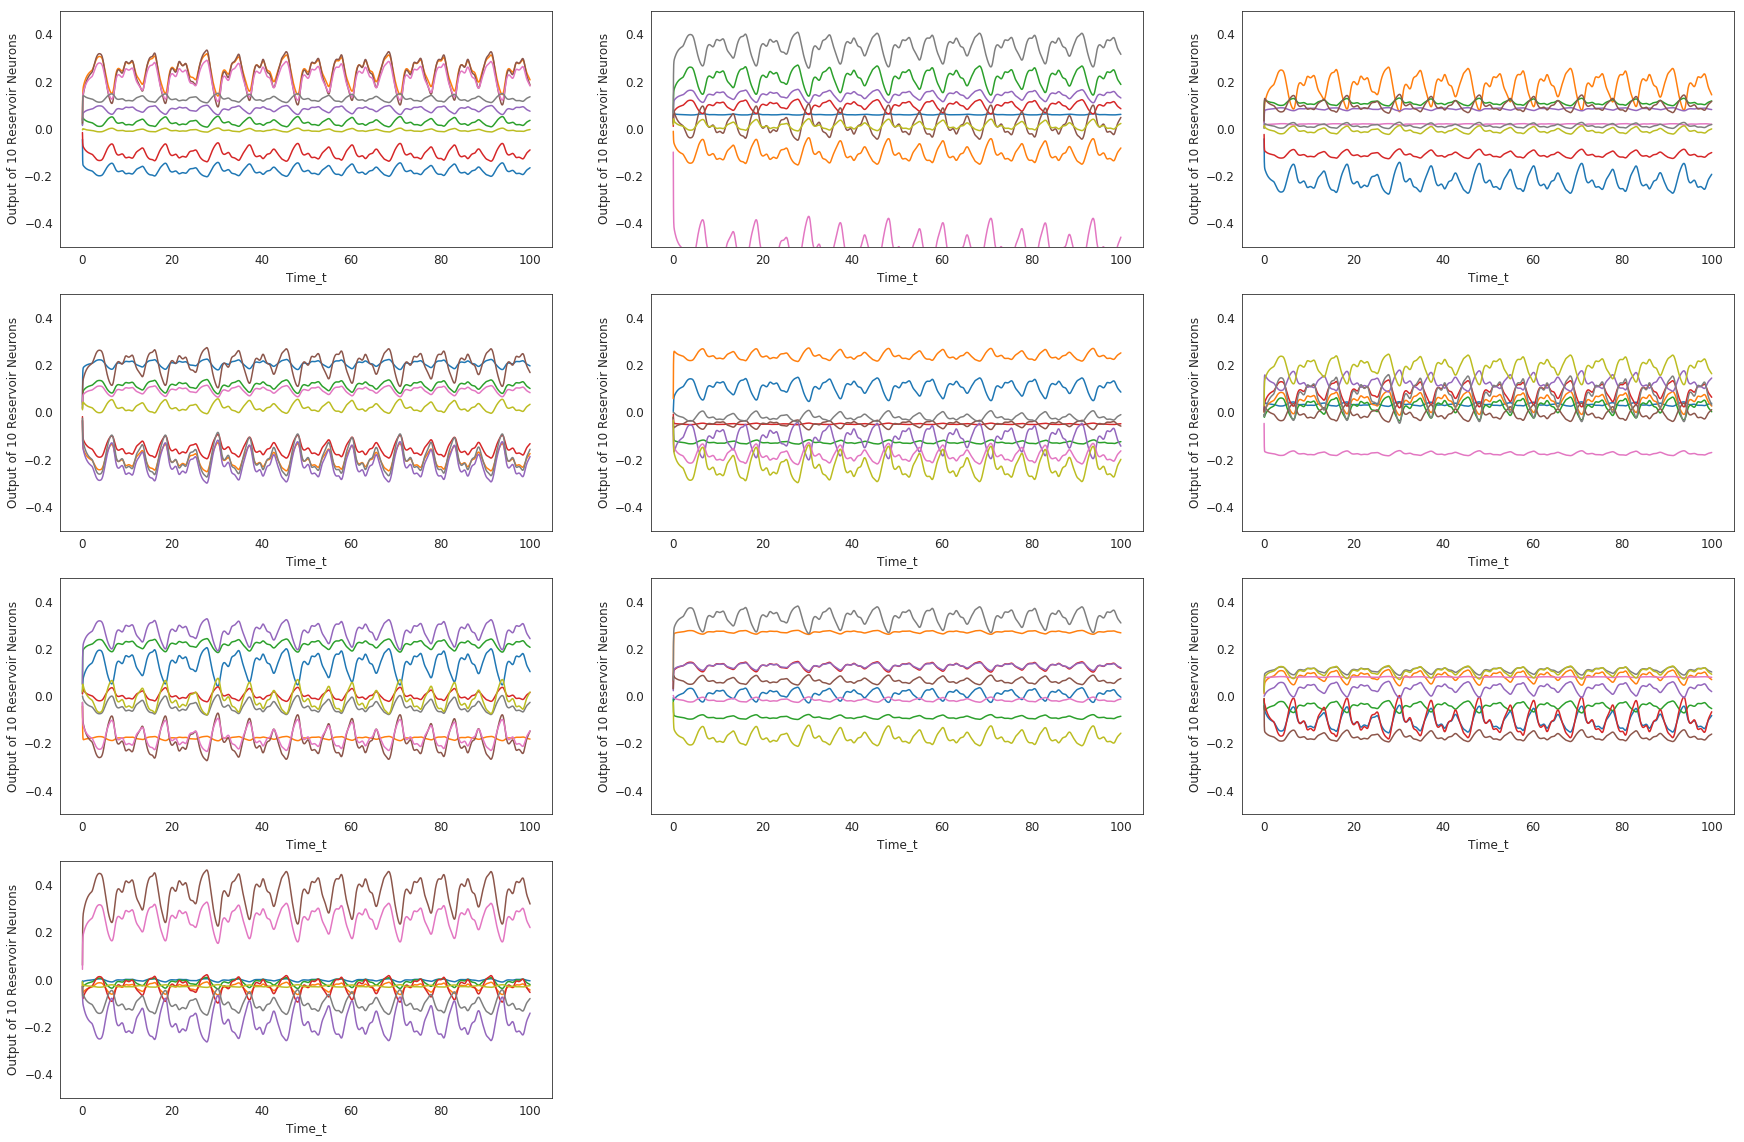

Mean Squared Error for n = 4.5 : 1.4271354280628867e-12


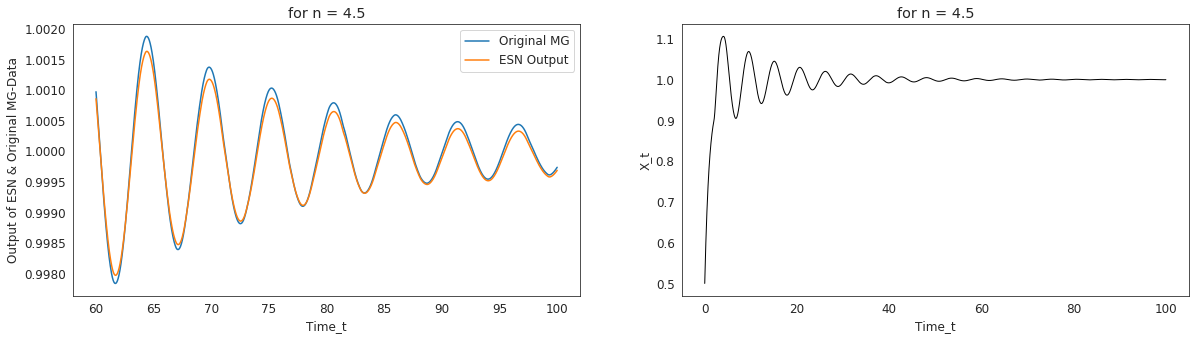

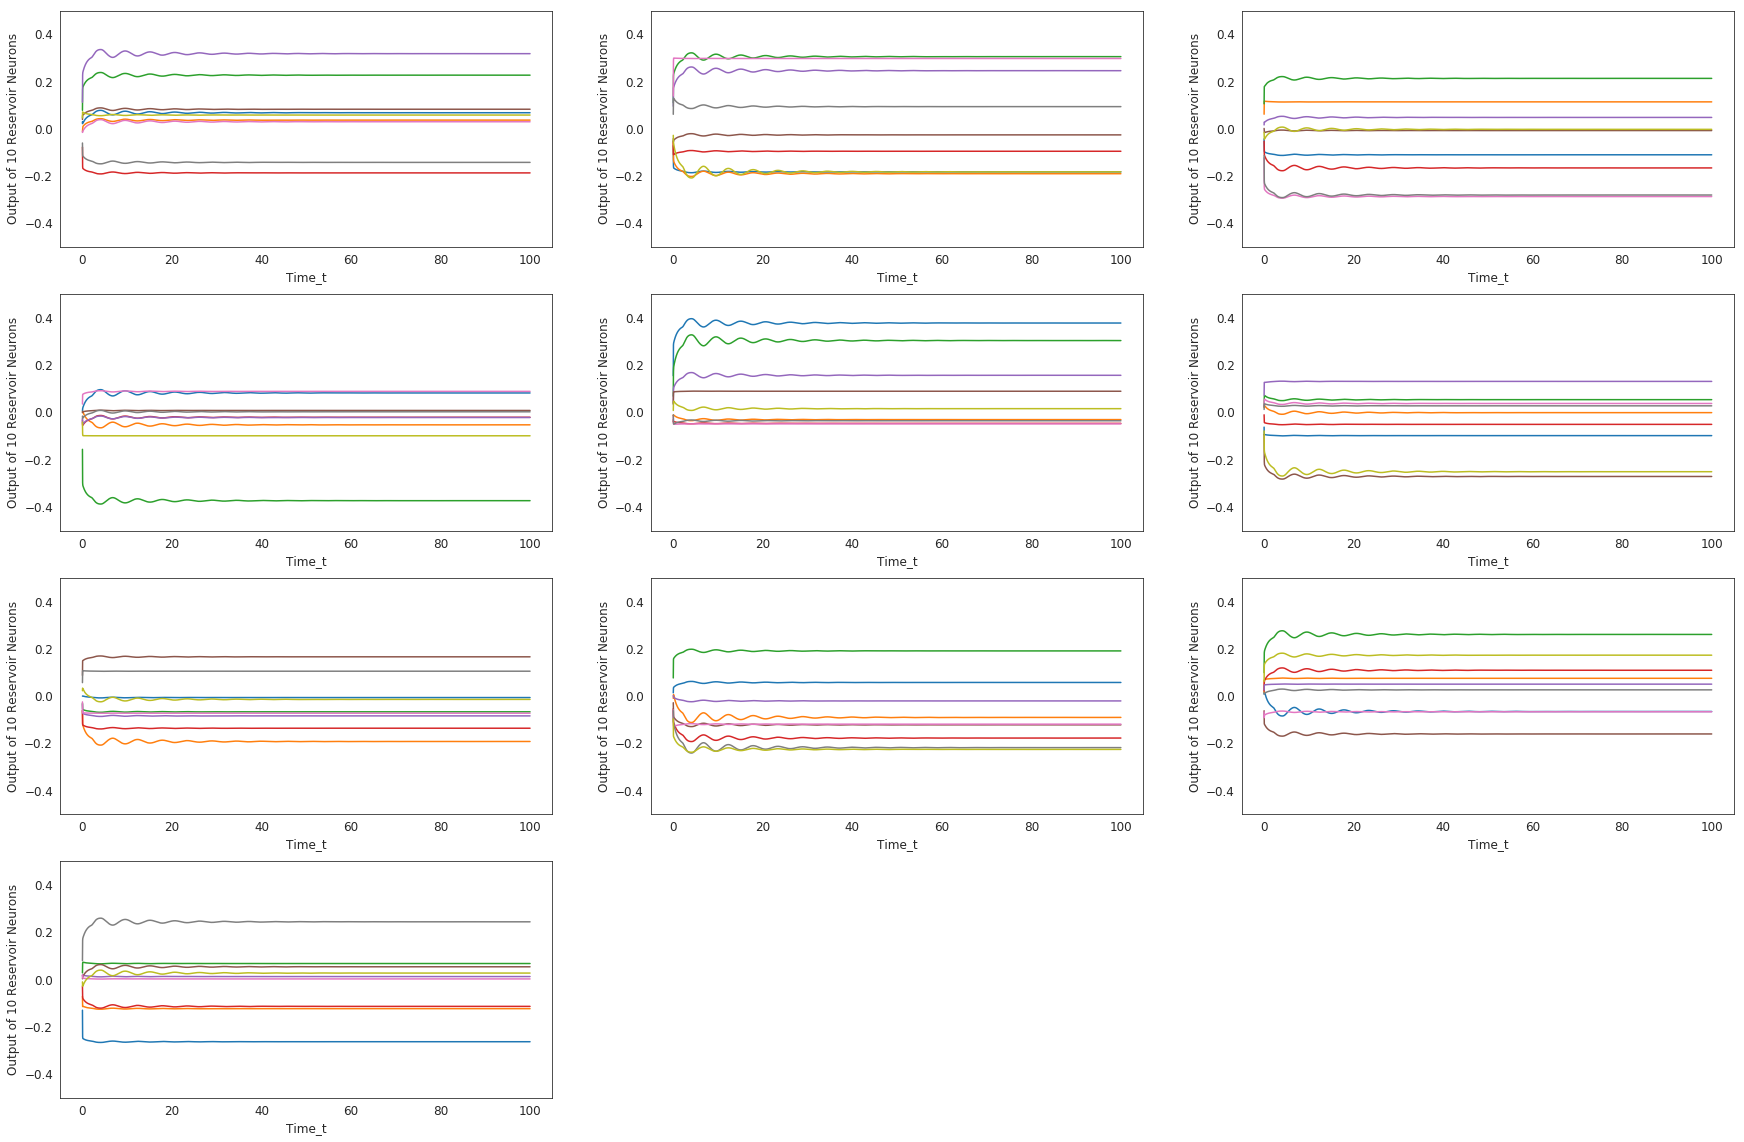

Mean Squared Error for n = 9.5 : 1.0082259471744237e-08


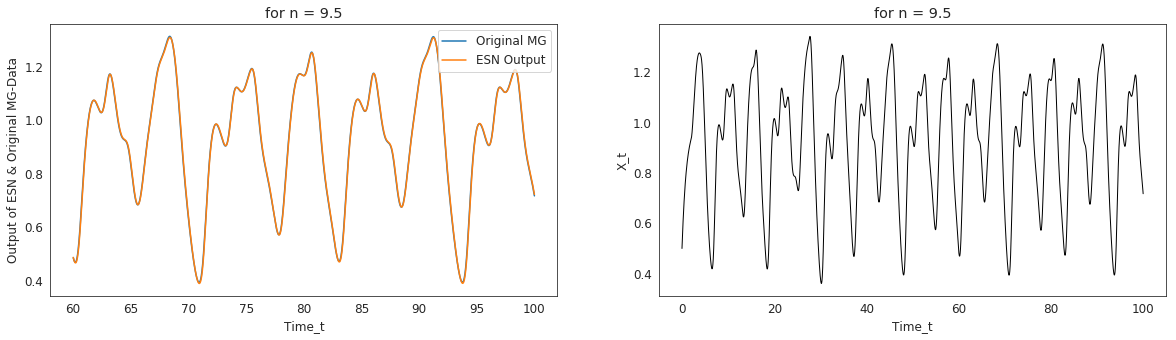

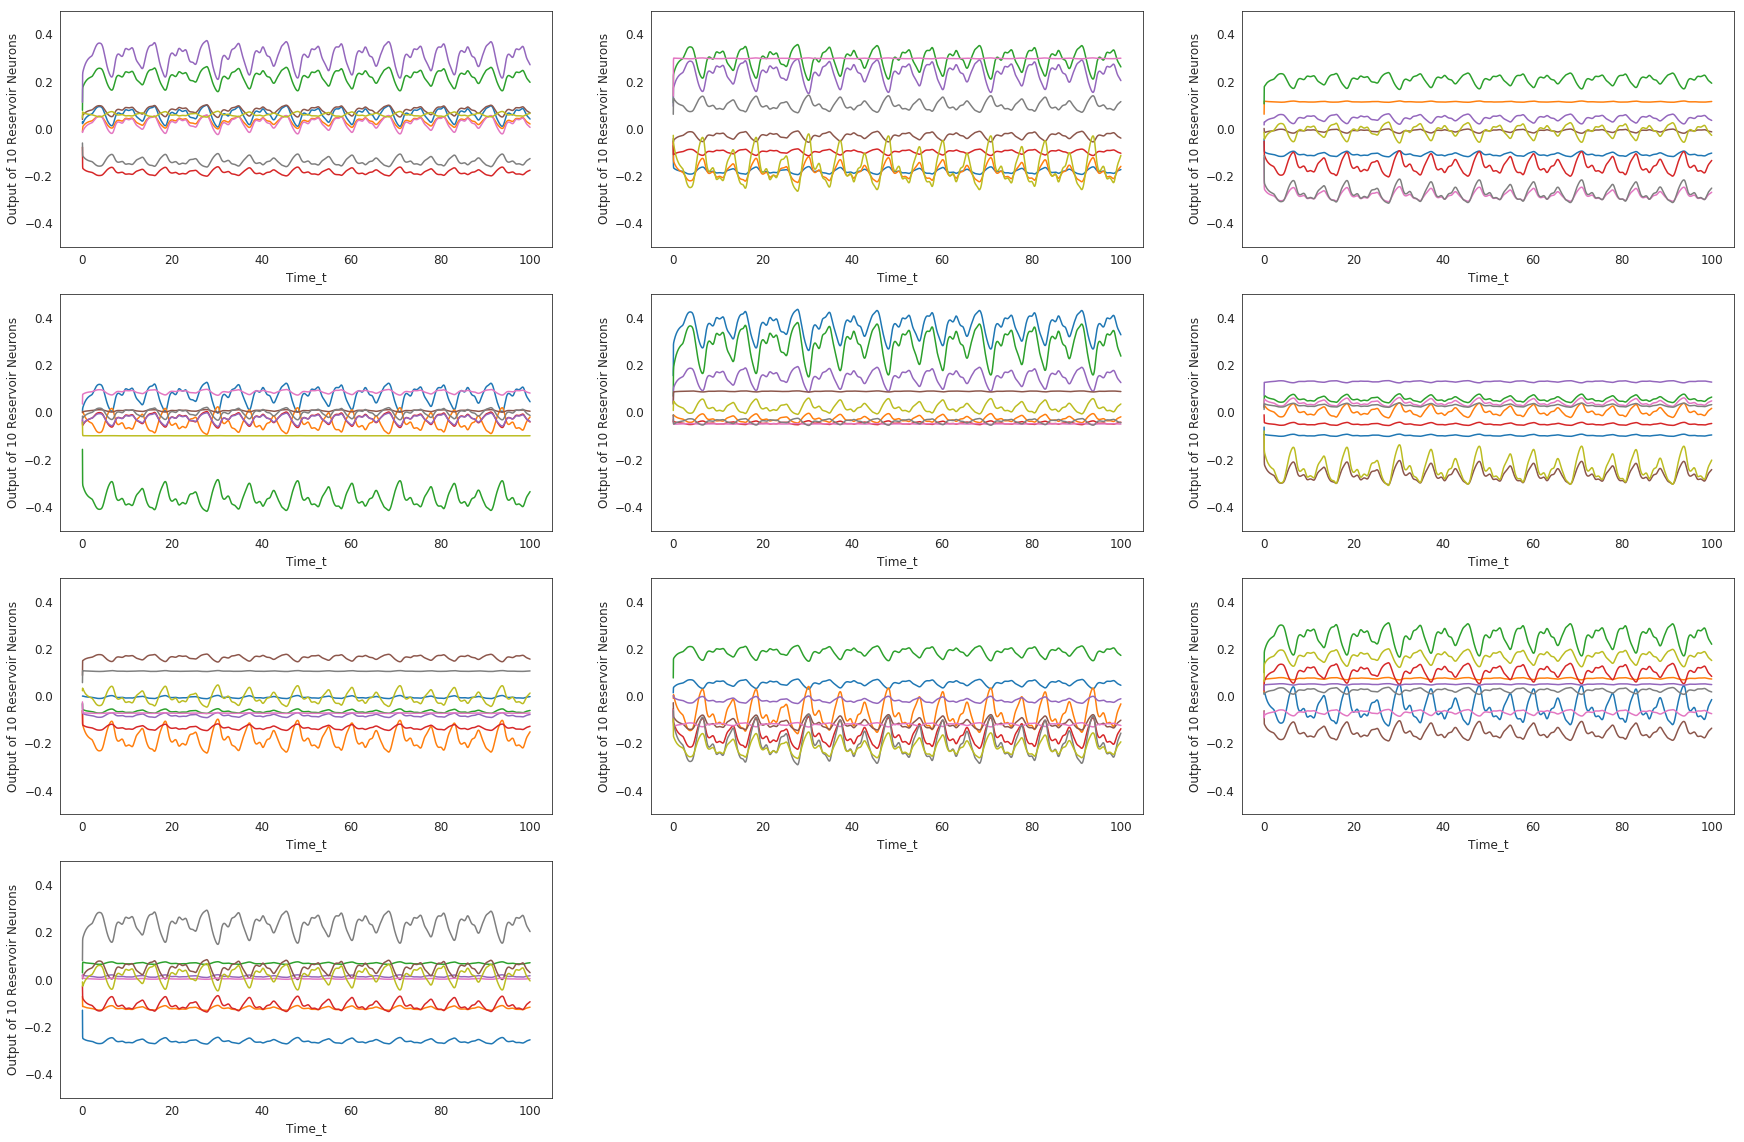

Mean Squared Error for n = 4.5 : 7.165499747371906e-13


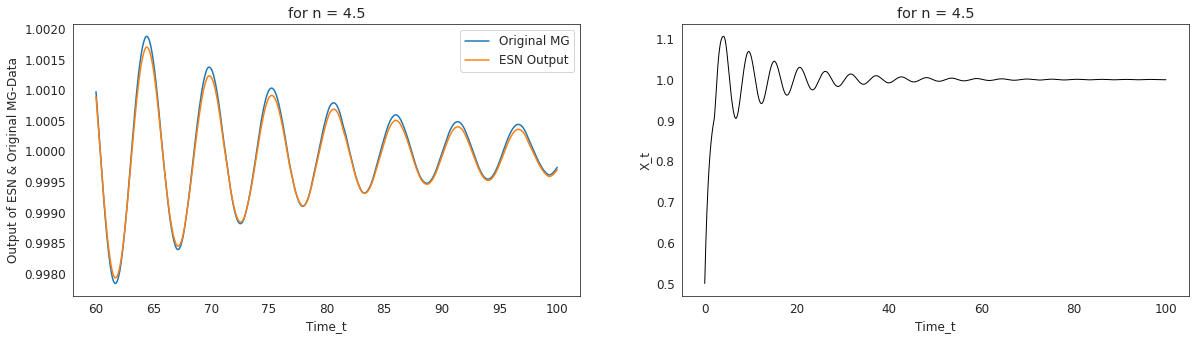

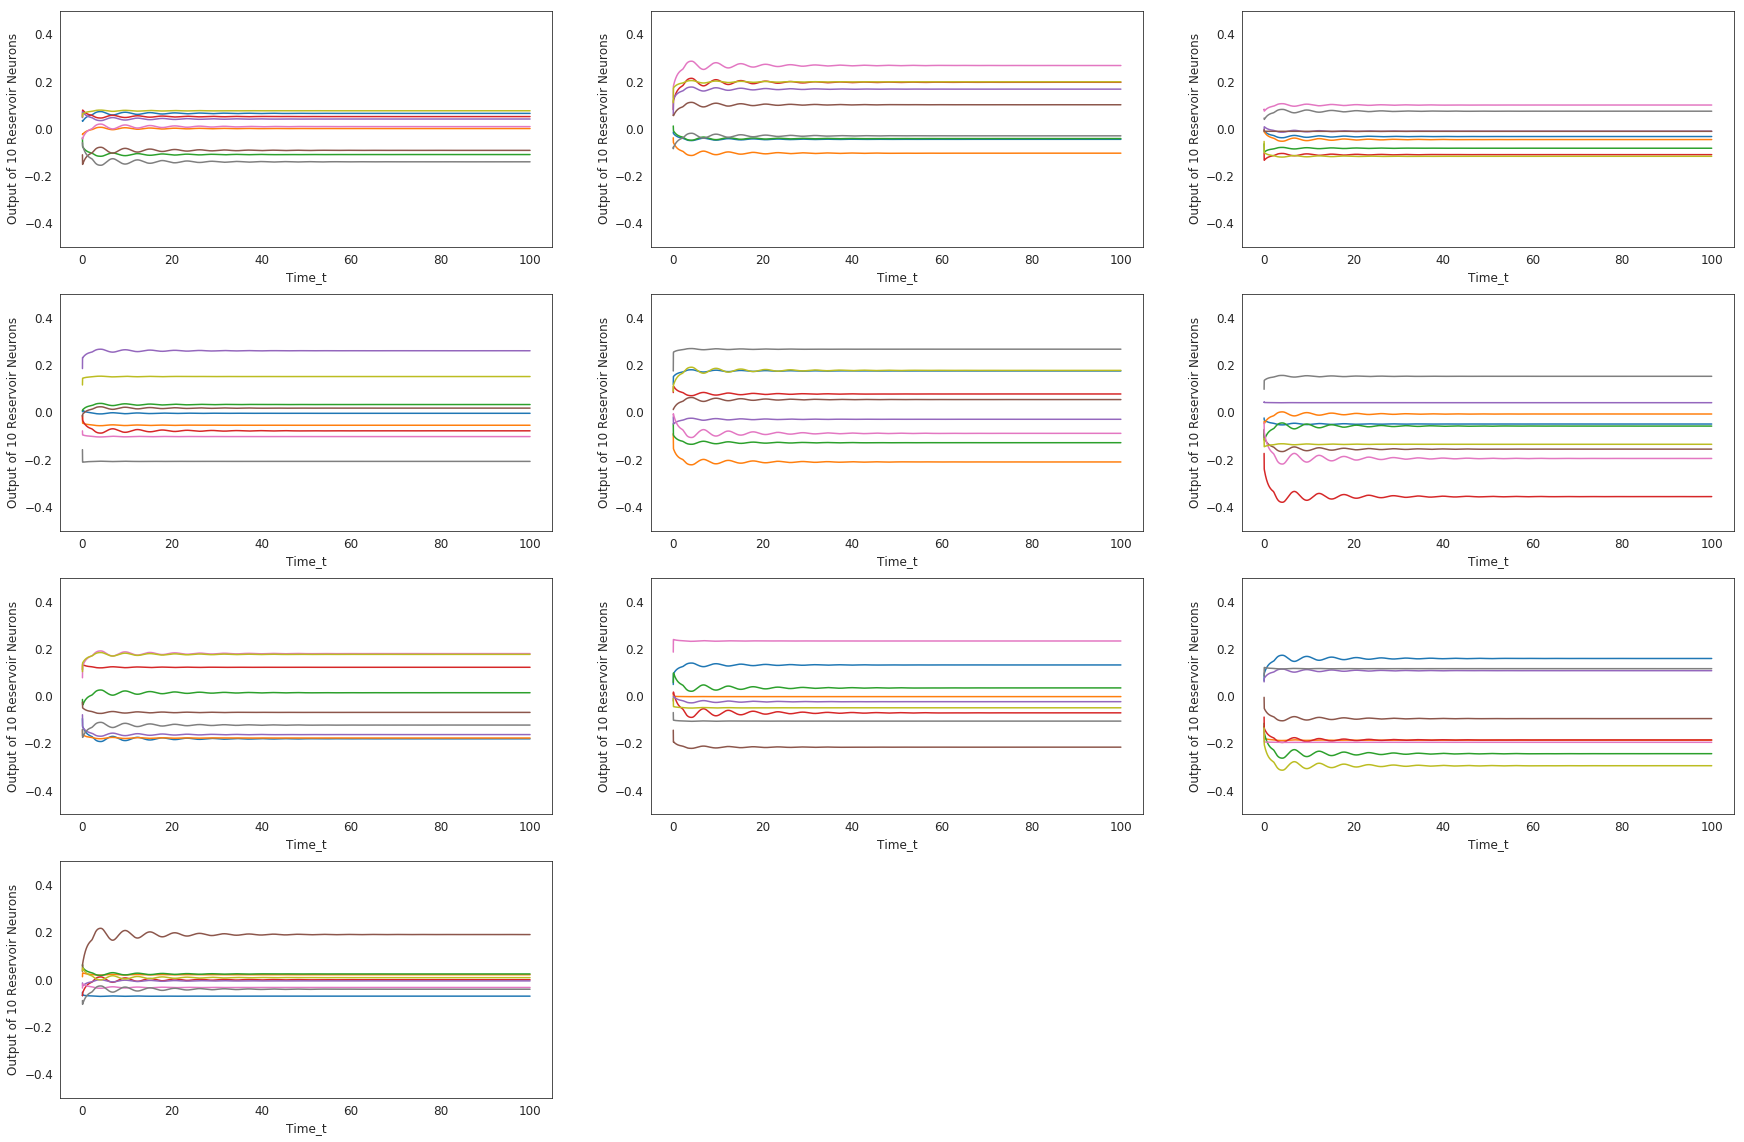

Mean Squared Error for n = 9.5 : 5.191642227231341e-09


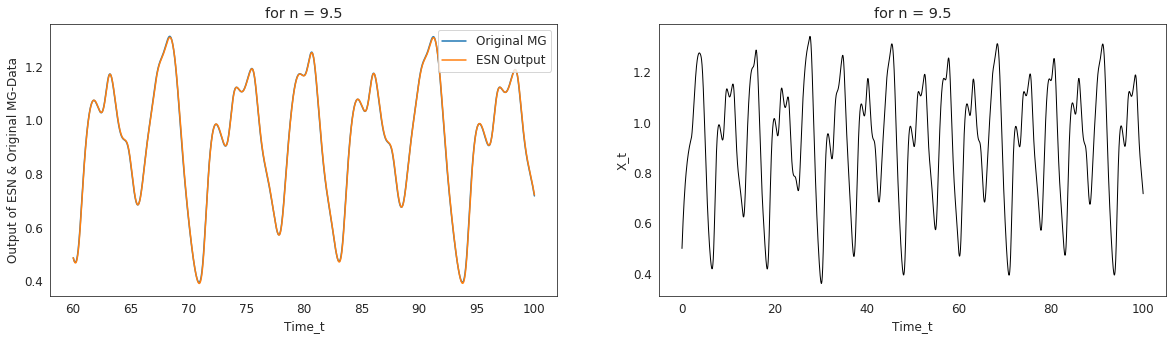

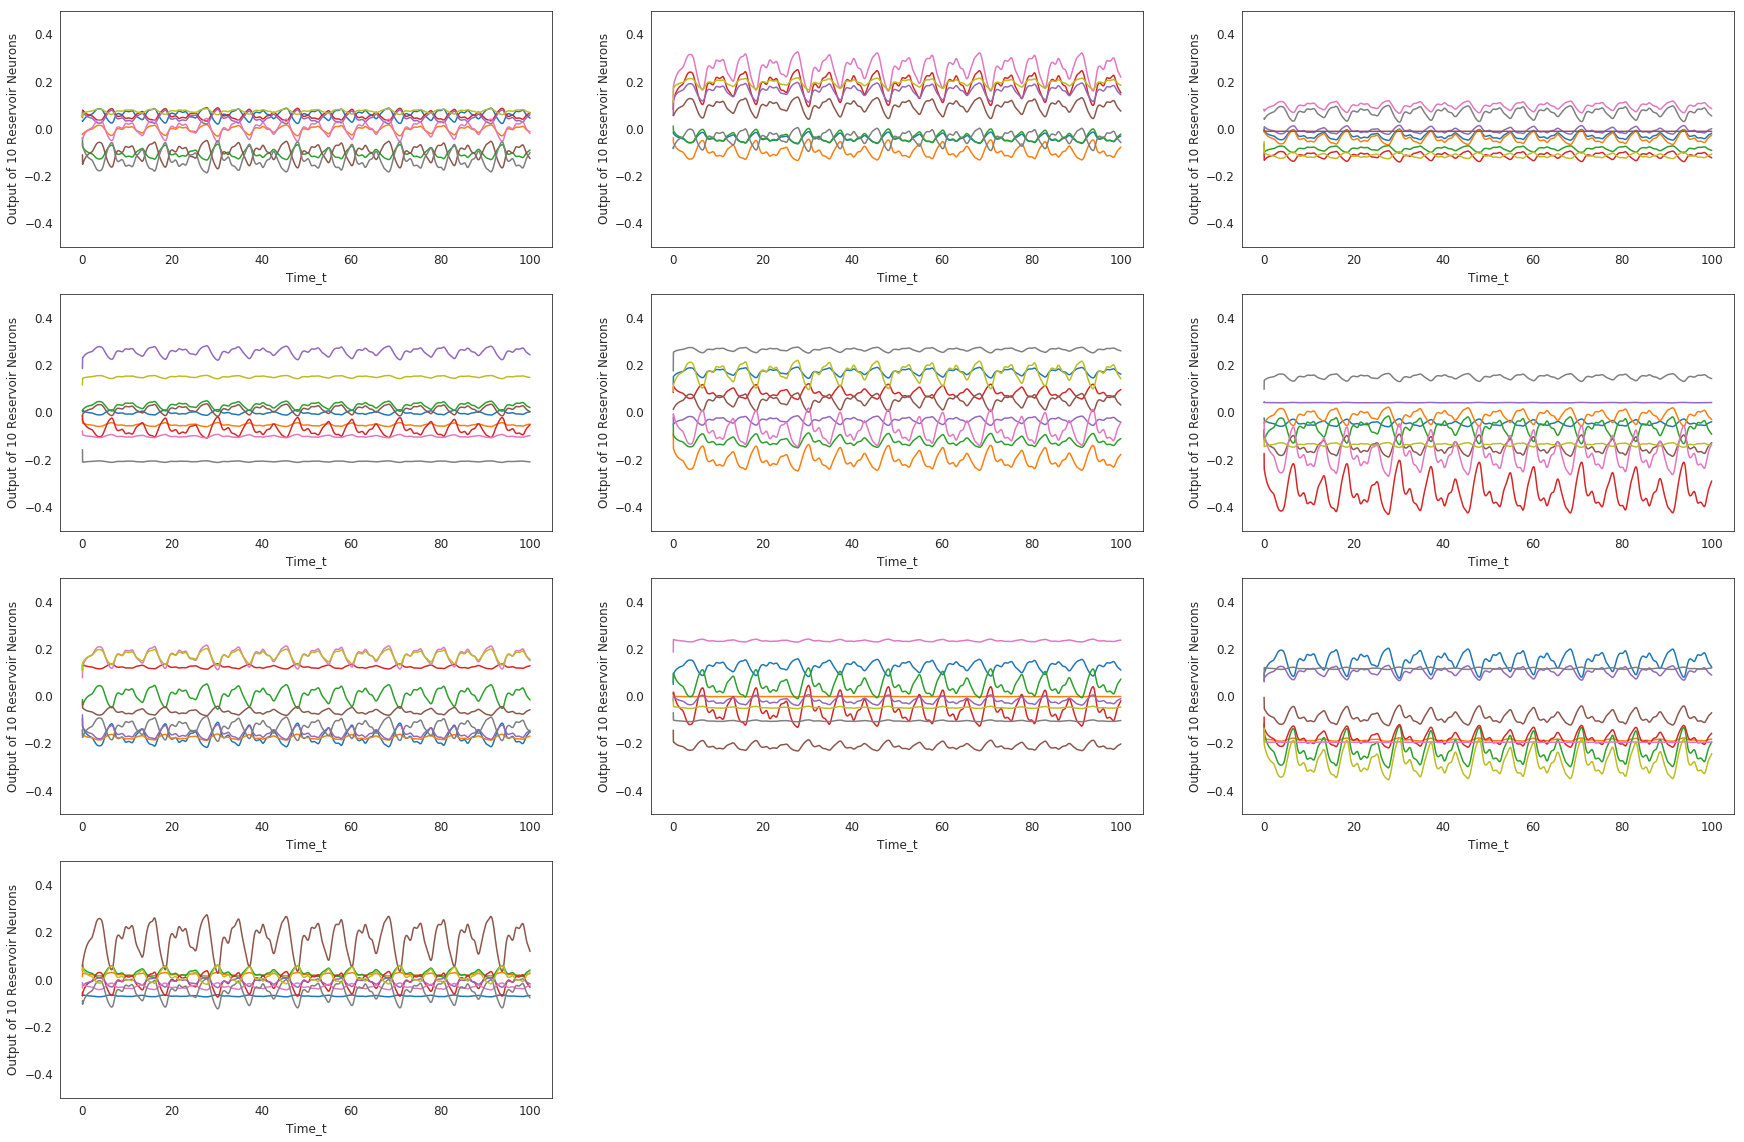

Mean Squared Error for n = 4.5 : 4.674996284190214e-13


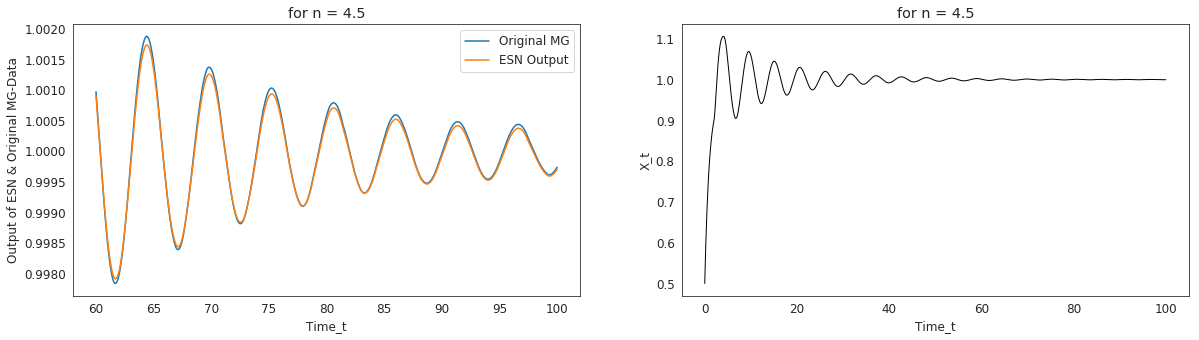

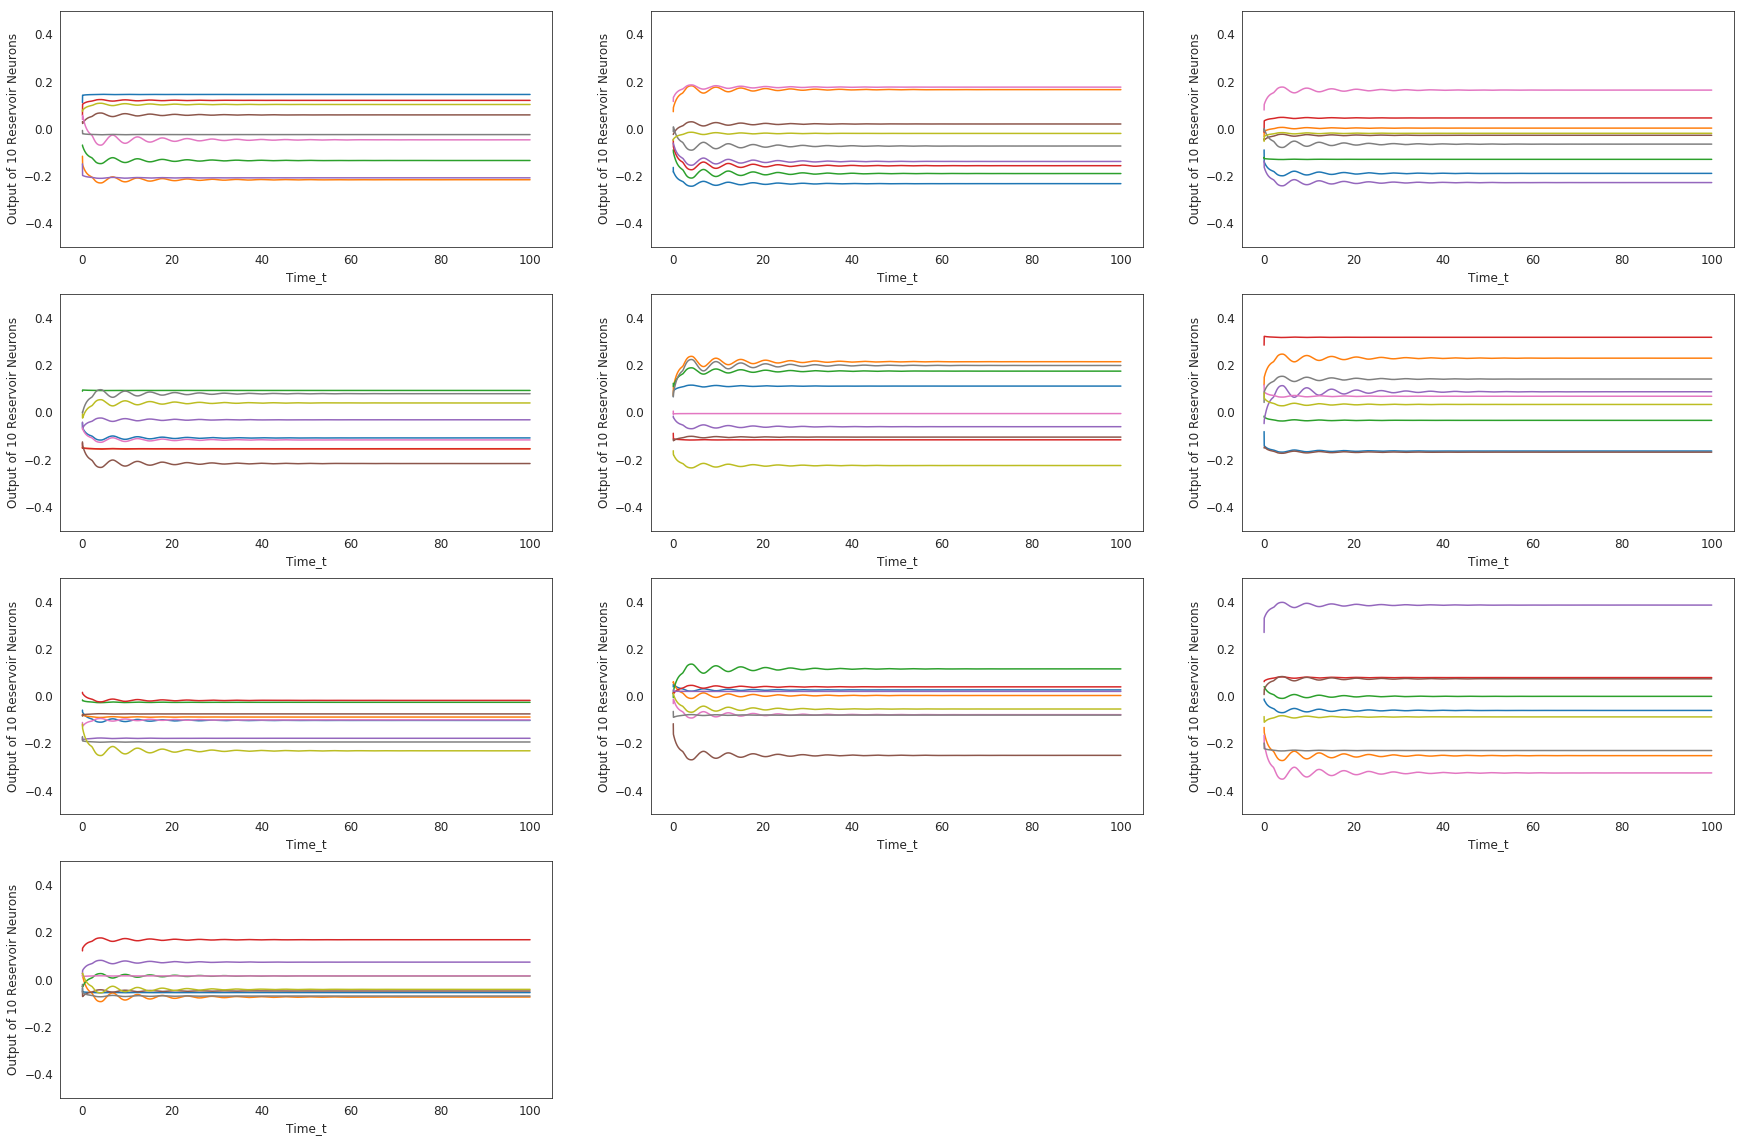

Mean Squared Error for n = 9.5 : 3.6634779654320937e-09


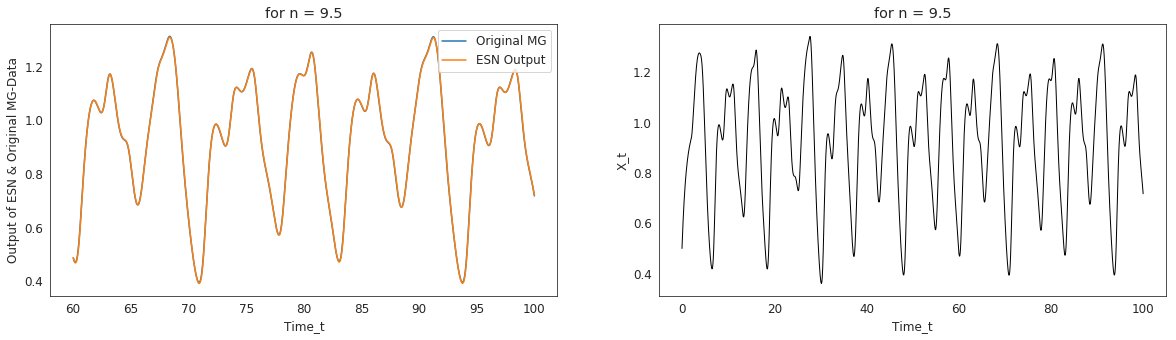

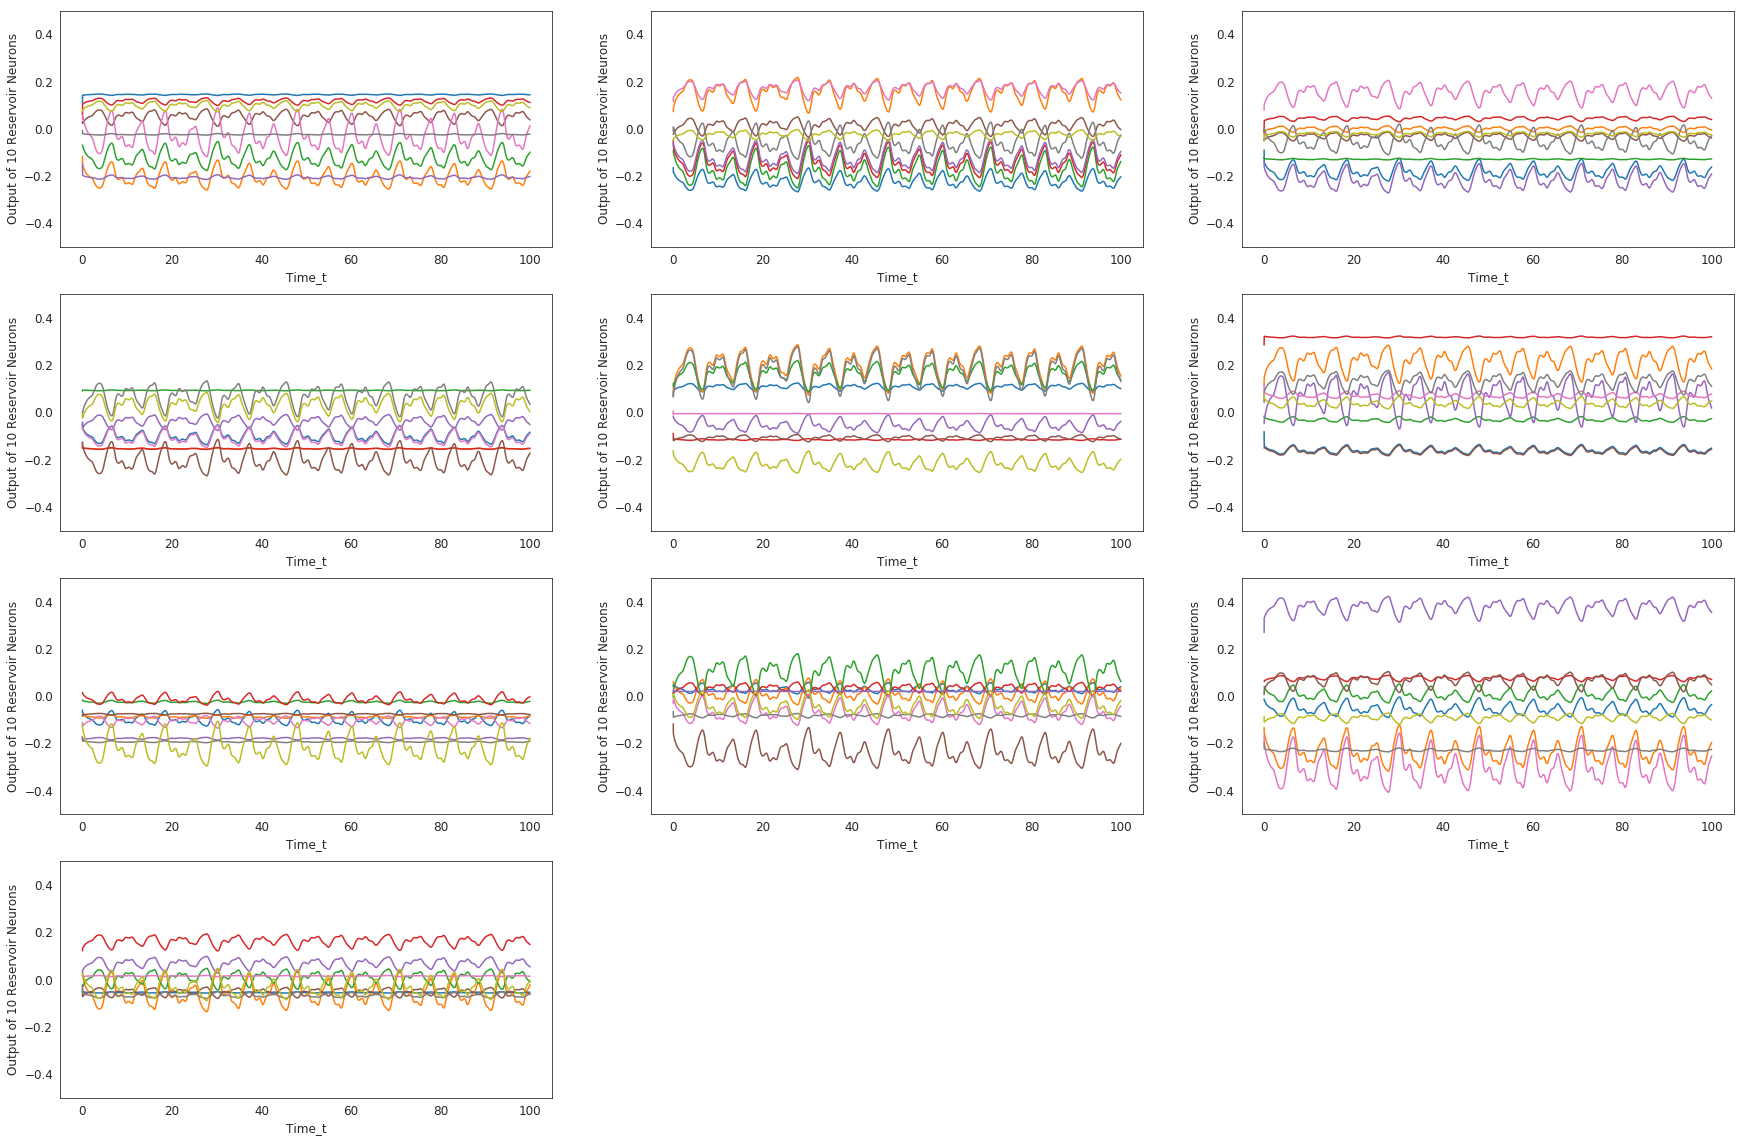

n  Spectral_Radius           MSE  alpha
1    4.50         0.999998  3.158444e-12   0.10
2    6.00         0.999998  4.982017e-08   0.10
3    7.50         0.999998  5.956964e-08   0.10
4    8.50         0.999998  6.834707e-08   0.10
5    9.50         0.999998  6.529202e-08   0.10
6    9.60         0.999998  6.484834e-08   0.10
7    9.65         0.999998  6.927350e-08   0.10
8    9.70         0.999998  6.451803e-08   0.10
9    9.80         0.999998  7.185481e-08   0.10
10   9.90         0.999998  7.545052e-08   0.10
11  10.00         0.999998  6.301908e-08   0.10
12  11.00         0.999998  8.137518e-08   0.10
13  15.00         0.999998  8.107033e-08   0.10
14  20.00         0.999998  9.341807e-08   0.10
1    4.50         1.001422  9.368480e-13   0.25
2    6.00         1.001422  1.459959e-08   0.25
3    7.50         1.001422  2.262951e-08   0.25
4    8.50         1.001422  2.667044e-08   0.25
5    9.50         1.001422  2.862323e-08   0.25
6    9.60         1.001422  2.877491e-08   0.25
7    9.65         1.001422  2.980806e-08   0.25
8    9.70         1.001422  2.900616e-08   0.25
9    9.80         1.001422  3.180986e-08   0.25
10   9.90         1.001422  3.445796e-08   0.25
11  10.00         1.001422  2.855460e-08   0.25
12  11.00         1.001422  4.038047e-08   0.25
13  15.00         1.001422  4.494632e-08   0.25
14  20.00         1.001422  4.854844e-08   0.25
1    4.50         0.999997  1.427135e-12   0.50
2    6.00         0.999997  4.062822e-09   0.50
..    ...              ...           ...    ...
13  15.00         0.999997  2.275590e-08   0.50
14  20.00         0.999997  2.563495e-08   0.50
1    4.50         1.054939  7.165500e-13   0.75
2    6.00         1.054939  2.020705e-09   0.75
3    7.50         1.054939  3.542093e-09   0.75
4    8.50         1.054939  4.593862e-09   0.75
5    9.50         1.054939  5.191642e-09   0.75
6    9.60         1.054939  5.305784e-09   0.75
7    9.65         1.054939  5.383267e-09   0.75
8    9.70         1.054939  5.414515e-09   0.75
9    9.80         1.054939  5.875450e-09   0.75
10   9.90         1.054939  6.710688e-09   0.75
11  10.00         1.054939  5.380004e-09   0.75
12  11.00         1.054939  8.484719e-09   0.75
13  15.00         1.054939  1.209159e-08   0.75
14  20.00         1.054939  1.366822e-08   0.75
1    4.50         0.955029  4.674996e-13   0.90
2    6.00         0.955029  1.395011e-09   0.90
3    7.50         0.955029  2.457705e-09   0.90
4    8.50         0.955029  3.287680e-09   0.90
5    9.50         0.955029  3.663478e-09   0.90
6    9.60         0.955029  3.735665e-09   0.90
7    9.65         0.955029  3.806433e-09   0.90
8    9.70         0.955029  3.845574e-09   0.90
9    9.80         0.955029  4.149922e-09   0.90
10   9.90         0.955029  4.805137e-09   0.90
11  10.00         0.955029  3.806803e-09   0.90
12  11.00         0.955029  6.071454e-09   0.90
13  15.00         0.955029  8.574840e-09   0.90
14  20.00         0.955029  9.664391e-09   0.90

[70 rows x 4 columns]

In [86]:
# bifurcation_para = [4.5, 6, 7.5, 8.5, 9.5, 9.6, 9.65, 9.7, 9.8, 9.9, 10, 11, 15, 20]

leakrates = [0.1, 0.25, 0.5, 0.75, 0.9]

df_all_alpha = []
check_n = [4.5, 9.5]
groupsize = 10


with tf.Session() as sess:

    for alpha in leakrates:
        
        sess.run(tf.global_variables_initializer())

        alpha = np.expand_dims(alpha, axis=0)
        init_esn_state = np.zeros([1, res_units], dtype="float32")

        plt.rcParams.update({'font.size': 12})

        for i, n in enumerate(X_ts_):

            spec_rad, w_r, w_i, outs, mse, ts_target, ts_out = sess.run([spectral_rad, w_res, w_in,\
                                                               outputs,MSE,test_target,test_out],\
                                                               feed_dict={leak_rate:alpha,\
                                                                          inputs:X_ts_[n],\
                                                                          init_state:init_esn_state})

            df = pd.DataFrame(columns=['n','Spectral_Radius','MSE','alpha'])
            df.loc[i+1] = [n, spec_rad, mse, alpha[-1]]
        
            df_all_alpha.append(df)

            if n in check_n:
                print("Mean Squared Error for n = {} : {}".format(n, mse))

                plt.figure(figsize=(20,5))
                plt.subplot(121)
                plt.plot(t[train_size+init_transient+1:], ts_target)
                plt.plot(t[train_size+init_transient+1:], ts_out)
                plt.title("for n = {}".format(n), loc='center')
                plt.xlabel("Time_t")
                plt.ylabel("Output of ESN & Original MG-Data".format(res_units))
                plt.legend(("Original MG","ESN Output"), loc = "upper right")
                plt.subplot(122)
                plt.plot(t, X_ts[n],label= "n = {}".format(n), color='black', lw=1.0)
                plt.title("for n = {}".format(n), loc='center')
                plt.xlabel("Time_t")
                plt.ylabel("X_t")

                start = 0
                plt.figure(figsize=(30,20))
                for i in range(groupsize):
                    plt.subplot(4,3,i+1)
                    plt.plot(t, outs[:,start:start+groupsize-1])
                    plt.xlabel("Time_t")
                    plt.ylabel("Output of {} Reservoir Neurons".format(int(res_units/groupsize)))
                    plt.ylim(-0.5, 0.5)
                    start = start+groupsize

                plt.show()


df_all_alpha = pd.concat(df_all_alpha)
df_all_alpha

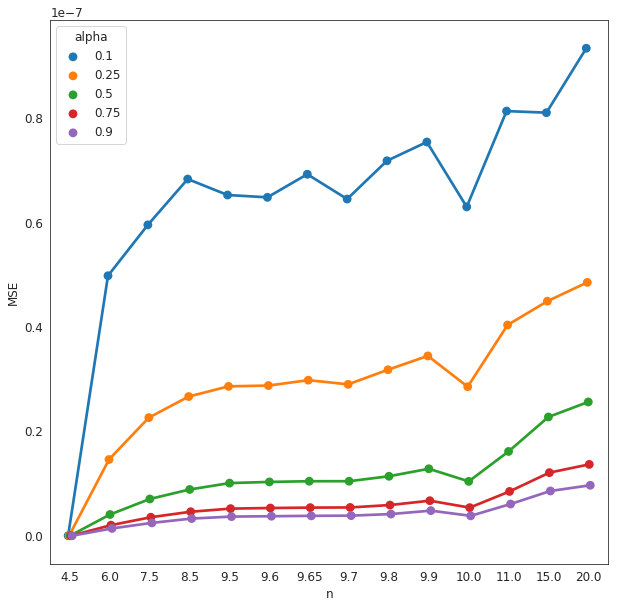

In [87]:
# Plot the pointplot

plt.figure(figsize=(10,10))
sns.set_style('white')
sns.pointplot(data=df_all_alpha, x='n', y='MSE', hue='alpha', dodge=0.1)
plt.show()

# END

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

#print(w_reservoir_1, '\n\n', w_reservoir_2)
#print(w_input_1, '\n\n', w_input_2)